# Exploring Bike Accident Data for Berlin

first visualization and exploration of destatis accident data, filtering for bicycle accidents 

## About the Data Set
* source: [Destatis Unfallatlas](https://unfallatlas.statistikportal.de/)
* [Licence](http://www.govdata.de/dl-de/by-2-0)
* for timespan of 2016-2024
* The Accident Atlas contains accidents with personal injury! Accidents involving only material damage are not shown.


In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
import geopandas as gpd
import shapely

## Read data from csv-files 

In [2]:
csv_dir = Path("data/csv")
csv_files = sorted(csv_dir.glob("*.csv"))

if not csv_files:
    raise FileNotFoundError(f"No CSV files found in {csv_dir.resolve()}")

dfs = []
for fp in csv_files:
    df = pd.read_csv(fp, low_memory=False, delimiter=";", decimal=",")
    df["source_file"] = fp.name 
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)
print(f"Loaded {len(csv_files)} files -> combined shape: {df_all.shape}")

df_all.drop(columns=["OBJECTID", "UIDENTSTLA", "OBJECTID_1", "UIDENTSTLAE", "OID_", "FID", "IstStrasse", "LICHT"], inplace=True)

df_all.head()

Loaded 9 files -> combined shape: (2098019, 35)


,ULAND,UREGBEZ,UKREIS,UGEMEINDE,UJAHR,UMONAT,USTUNDE,UWOCHENTAG,UKATEGORIE,UART,...,LINREFX,LINREFY,XGCSWGS84,YGCSWGS84,source_file,ULICHTVERH,IstGkfz,IstSonstige,IstStrassenzustand,PLST
0,1,0,55,12,2017,1,5,6,2,9,...,605079.4229,6.001758e+06,10.609031,54.153150,Unfallorte2017_LinRef.csv,NaN,NaN,NaN,NaN,NaN
1,1,0,60,53,2017,1,6,6,3,6,...,582297.2184,5.969289e+06,10.251498,53.865551,Unfallorte2017_LinRef.csv,NaN,NaN,NaN,NaN,NaN
2,1,0,61,11,2017,1,18,6,3,7,...,522799.3000,5.990576e+06,9.348344,54.062897,Unfallorte2017_LinRef.csv,NaN,NaN,NaN,NaN,NaN
3,1,0,55,42,2017,1,12,7,3,5,...,616128.9378,5.981557e+06,10.770405,53.969302,Unfallorte2017_LinRef.csv,NaN,NaN,NaN,NaN,NaN
4,1,0,62,60,2017,1,8,6,3,2,...,581575.9987,5.934905e+06,10.231475,53.556684,Unfallorte2017_LinRef.csv,NaN,NaN,NaN,NaN,NaN


In [3]:
# drop all accidents that did not involve bicycles (column 'IstRad' != 1)
df_bike = df_all[df_all['IstRad'] == 1].copy()
print(f"Filtered to bicycle accidents -> shape: {df_bike.shape}")

# only keep accidents in Berlin (column 'ULAND' == 11)
df_bike_berlin = df_bike[df_bike['ULAND'] == 11].copy()
print(f"Filtered to bicycle accidents in Berlin -> shape: {df_bike_berlin.shape}")
df_bike_berlin.head()

Filtered to bicycle accidents -> shape: (626844, 27)
Filtered to bicycle accidents in Berlin -> shape: (33181, 27)


,ULAND,UREGBEZ,UKREIS,UGEMEINDE,UJAHR,UMONAT,USTUNDE,UWOCHENTAG,UKATEGORIE,UART,...,LINREFX,LINREFY,XGCSWGS84,YGCSWGS84,source_file,ULICHTVERH,IstGkfz,IstSonstige,IstStrassenzustand,PLST
307975,11,0,3,3,2018,1,15,4,3,6,...,798261.3849,5.835047e+06,13.403228,52.583472,Unfallorte2018_LinRef.csv,1.0,0.0,NaN,NaN,NaN
308120,11,0,3,3,2018,1,11,5,3,5,...,800551.7210,5.829808e+06,13.432186,52.535255,Unfallorte2018_LinRef.csv,0.0,0.0,NaN,NaN,NaN
308130,11,0,2,2,2018,1,8,2,3,5,...,803320.7292,5.827627e+06,13.470897,52.514173,Unfallorte2018_LinRef.csv,0.0,0.0,NaN,NaN,NaN
308149,11,0,1,1,2018,1,19,4,3,5,...,798174.6913,5.826940e+06,13.394673,52.510848,Unfallorte2018_LinRef.csv,2.0,0.0,NaN,NaN,NaN
308175,11,0,9,9,2018,1,18,4,2,5,...,806109.6297,5.821644e+06,13.506372,52.458993,Unfallorte2018_LinRef.csv,2.0,0.0,NaN,NaN,NaN


## First Explorative Plots
### Accidents by Weekday

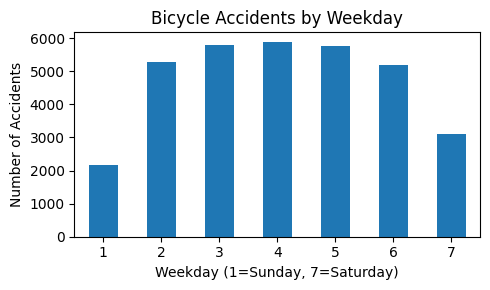

In [4]:
# plot number of accidents by weekday ('UWOCHENTAG')
weekday_counts = df_bike_berlin['UWOCHENTAG'].value_counts().sort_index()

plt.figure(figsize=(5, 3))
weekday_counts.plot(kind='bar')
plt.xlabel('Weekday (1=Sunday, 7=Saturday)')
plt.ylabel('Number of Accidents')
plt.title('Bicycle Accidents by Weekday')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Accidents by hour of the day

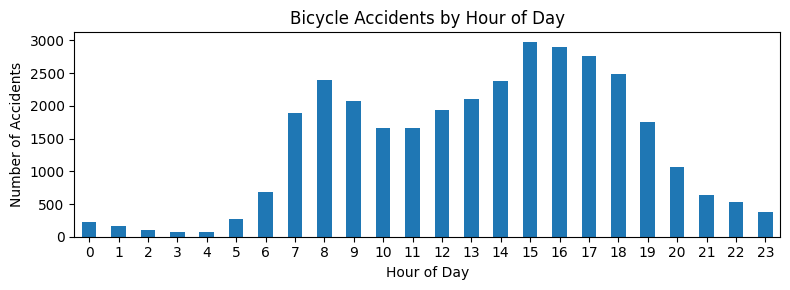

In [5]:
# plot number of accidents by hour of day ('USTUNDE')
hour_counts = df_bike_berlin['USTUNDE'].value_counts().sort_index()
plt.figure(figsize=(8, 3))
hour_counts.plot(kind='bar')    
plt.xlabel('Hour of Day')
plt.ylabel('Number of Accidents')
plt.title('Bicycle Accidents by Hour of Day')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Accidents by Month

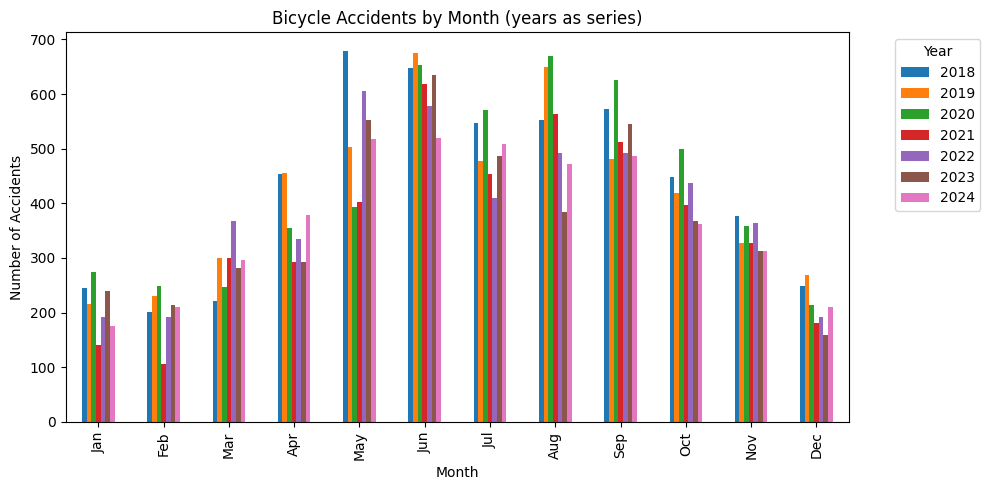

In [6]:
# plot months on the x-axis and years as series (switch year and month)
month_year_counts = df_bike_berlin.groupby(['UMONAT', 'UJAHR']).size().unstack(fill_value=0)
month_year_counts = month_year_counts.sort_index()

# replace numeric month index with short names for readability
month_names = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
month_year_counts.index = month_year_counts.index.map(lambda m: month_names[m-1] if 1 <= m <= 12 else str(m))

month_year_counts.plot(kind='bar', figsize=(10, 5))
plt.xlabel('Month')
plt.ylabel('Number of Accidents')
plt.title('Bicycle Accidents by Month (years as series)')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
  

### Severity of Injuries
* Seperated in three categories:
    1) Accident with persons killed
    2) Accident with seriously injured
    3) Accident with slightly injured

<Figure size 2800x500 with 0 Axes>

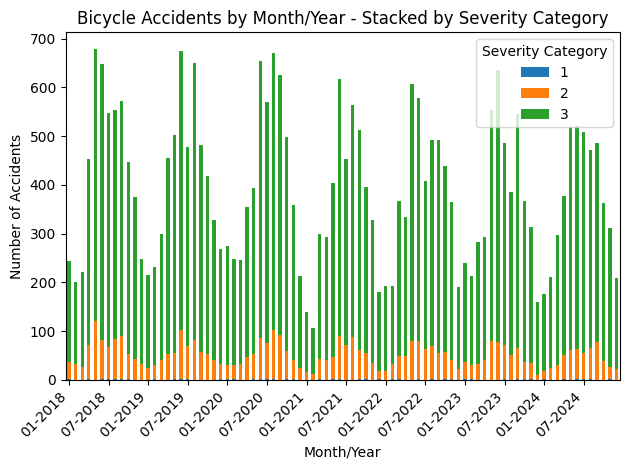

In [7]:
# plot stacked bar chart of accident severity by month/year
# create date column for grouping by month and year
df_bike_berlin['date'] = pd.to_datetime({'year': df_bike_berlin['UJAHR'], 'month': df_bike_berlin['UMONAT'], 'day':1})

# group by date and severity category
severity_date_counts = df_bike_berlin.groupby(['date', 'UKATEGORIE']).size().unstack(fill_value=0)
plt.figure(figsize=(28, 5))
severity_date_counts.plot(kind='bar', stacked=True)
plt.xlabel('Month/Year')
plt.ylabel('Number of Accidents')
plt.title('Bicycle Accidents by Month/Year - Stacked by Severity Category')
plt.legend(title='Severity Category')

# Set x-axis ticks to every sixth month with year and month labels
ax = plt.gca()
ticks = range(0, len(severity_date_counts), 6)
labels = [severity_date_counts.index[i].strftime('%m-%Y') for i in ticks]
ax.set_xticks(ticks)
ax.set_xticklabels(labels, rotation=45, ha='right')

plt.tight_layout()
plt.show()

### Bike Accidents over Time

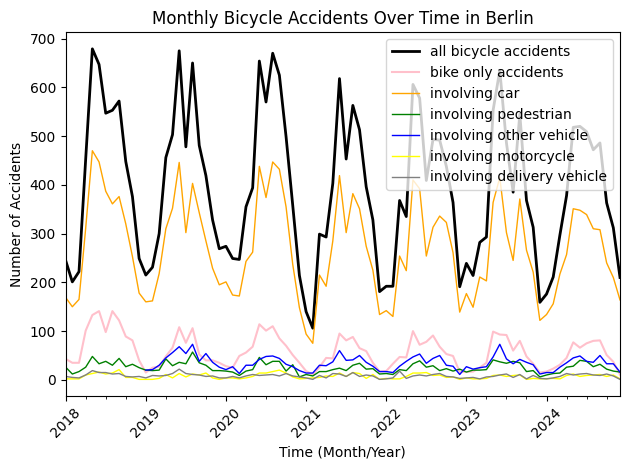

In [8]:
# plot curve on accident numbers over years with granularity of months
# add date column to dataframe, set day to 1 for all entries because no actual date info is available
df_bike_berlin['date'] = pd.to_datetime({'year': df_bike_berlin['UJAHR'], 'month': df_bike_berlin['UMONAT'], 'day':1})

monthly_counts_all = df_bike_berlin.groupby('date').size()
monthly_counts_all.plot(color='black', label='all bicycle accidents', linewidth=2)
monthly_counts_bike_only = df_bike_berlin[(df_bike_berlin['IstPKW'] != 1) & (df_bike_berlin['IstFuss'] != 1) & (df_bike_berlin['IstSonstige'] != 1) & (df_bike_berlin['IstKrad'] != 1) & (df_bike_berlin['IstGkfz'] != 1)].groupby('date').size()
monthly_counts_bike_only.plot(color='pink', label='bike only accidents')

subgroups = [['IstPKW', 'orange', 'involving car'],
             ['IstFuss', 'green', 'involving pedestrian'],
             ['IstSonstige', 'blue', 'involving other vehicle'],
             ['IstKrad', 'yellow', 'involving motorcycle'],
             ['IstGkfz', 'gray', 'involving delivery vehicle']]
for group, color, name in subgroups:
    monthly_counts_subgroup = df_bike_berlin[df_bike_berlin[group] == 1].groupby('date').size()
    monthly_counts_subgroup.plot(label=name, color=color, linewidth=1)

plt.legend()
plt.xlabel('Time (Month/Year)')
plt.ylabel('Number of Accidents')
plt.title('Monthly Bicycle Accidents Over Time in Berlin')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Map with Dots for each Bike Accident
* creates map with dots for each accident
* colors representing accident opponent vehicle:
    * orange: car
    * green: pedestrian
    * yellow: motorcycle
    * gray: goods road vehicle
    * blue: other vehicle (e.g. bus or tram)
    * beige: only bicycle involved

In [9]:
# map accident locations using folium
map_center = [52.52, 13.40]  # Center of Berlin
accident_map = folium.Map(location=map_center, zoom_start=12) 

for _, row in df_bike_berlin.iterrows():
    lat = row['YGCSWGS84']  
    lon = row['XGCSWGS84']  
    if pd.notnull(lat) and pd.notnull(lon):
        folium.CircleMarker(
            location=[lat, lon],
            radius=1,
            # set color according to involvement of car or pedestrian or other vehicles
            color='orange' if row['IstPKW'] == 1 else 'green' if row['IstFuss'] == 1 else 'yellow' if row['IstKrad'] == 1 else 'gray' if row['IstGkfz'] == 1 else 'blue' if row['IstSonstige'] == 1 else 'beige',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        ).add_to(accident_map)
accident_map.save("bicycle_accidents_berlin.html")


In [10]:
#create heat map of accident locations
heat_data = df_bike_berlin[["YGCSWGS84", "XGCSWGS84"]].values.tolist()
m = folium.Map(location=[52.52, 13.40], zoom_start=15)
HeatMap(heat_data, radius=15).add_to(m)
m.save("bicycle_accidents_heatmap_berlin.html")

# Spatial Join

## Clean Dataset for Accidents with locations outside the Strava Streetsegments
### Attempt 1: Use spatial join to assign segments to the accident locations
Challenges:
* need buffer on the accident locations -> what's the right size?
* because of the buffering, some accident locations have more than one segments assigned to them

notice how the joined dataset for 15m buffer is bigger than the original one. This is due to duplicate accidents that are assigned to more than one segment and therefore duplicated in the spatial join.

### Attempt 2: Use sjoin_nearest to assign exactly one (the nearest) segment to each accident
Challenges:
* need to find the right maximum distance so accidents that are not on a segment are not assigned to one.
* assigns two segments if their distance is equal

In [37]:
# This code uses sjoin_nearest (attempt 2)
# load data
strava_segments = pd.read_parquet(path="data/strava_data/berlin_graph_geometry.parquet")
strava_segments["geometry"] = strava_segments["geometry"].apply(shapely.wkt.loads)
df_bike_berlin = df_bike_berlin.reset_index(drop=True)

# transform strava segments and accident locations to GeoDataFrames
strava_segments_gdf = gpd.GeoDataFrame(strava_segments, geometry="geometry", crs="EPSG:4326")
accident_locations_gdf = gpd.GeoDataFrame(df_bike_berlin, geometry=gpd.points_from_xy(df_bike_berlin.XGCSWGS84, df_bike_berlin.YGCSWGS84), crs="EPSG:4326")
accident_locations_gdf = accident_locations_gdf.to_crs("EPSG:32633")
strava_segments_gdf = strava_segments_gdf.to_crs("EPSG:32633")

# Add identifier to accidents
accident_locations_gdf = accident_locations_gdf.reset_index(drop=True)
accident_locations_gdf["acc_id"] = accident_locations_gdf.index

# Compute nearest segment
joined = gpd.sjoin_nearest(
    accident_locations_gdf,
    strava_segments_gdf,
    how="left",
    max_distance=17, # hyperparameter that can be tuned to make assignments as accurate as possible
    distance_col="dist"
)

# drop accidents without assigned segment (NaN in index_right)
joined = joined.dropna(subset=["index_right"])

# drop duplicate accidents (by distance to segment)
joined_nearest_unique = (
    joined
    .sort_values("dist")
    .drop_duplicates(subset=["acc_id"], keep="first")
)


print(f"Total accidents: {len(accident_locations_gdf)}")
print(f"Total segments: {len(strava_segments_gdf)}")
print(f"Accidents assigned to segments: {len(joined_nearest_unique)}")
print (f"Accidents with ambiguous nearest segment: {len(joined) - len(joined_nearest_unique)}")
print(f"ratio of assigned accidents: {len(joined_nearest_unique) / len(accident_locations_gdf):.2%}")

strava_segments_gdf = gpd.GeoDataFrame(strava_segments, geometry="geometry", crs="EPSG:4326")
accident_locations_gdf = gpd.GeoDataFrame(df_bike_berlin, geometry=gpd.points_from_xy(df_bike_berlin.LINREFX, df_bike_berlin.LINREFY), crs="EPSG:4326")

joined_nearest_unique.head()

Total accidents: 33181
Total segments: 4958
Accidents assigned to segments: 25125
Accidents with ambiguous nearest segment: 37
ratio of assigned accidents: 75.72%


,ULAND,UREGBEZ,UKREIS,UGEMEINDE,UJAHR,UMONAT,USTUNDE,UWOCHENTAG,UKATEGORIE,UART,...,IstStrassenzustand,PLST,date,geometry,acc_id,index_right,counter_name,latitude,longitude,dist
29872,11,0,9,9,2021,4,9,4,2,1,...,0.0,NaN,2021-04-01,POINT (397322.52 5813776.685),29872,4661.0,streetsegment_4661,52.461939,13.492277,0.000047
25448,11,0,5,5,2024,3,9,1,3,5,...,0.0,1.0,2024-03-01,POINT (377489.976 5821932.897),25448,4436.0,streetsegment_4436,52.533763,13.194189,0.000098
9074,11,0,9,9,2019,9,6,4,3,5,...,NaN,NaN,2019-09-01,POINT (405293.008 5812309.772),9074,2567.0,streetsegment_2567,52.452859,13.606787,0.000193
6943,11,0,12,12,2019,5,16,5,3,5,...,NaN,NaN,2019-05-01,POINT (385705.621 5826533.591),6943,1210.0,streetsegment_1210,52.577151,13.310916,0.000222
7115,11,0,9,9,2019,5,18,3,1,0,...,NaN,NaN,2019-05-01,POINT (410373.006 5803066.518),7115,4637.0,streetsegment_4637,52.371061,13.677376,0.000236


### CHECK HOW WELL SPATIAL JOIN WORKS:  This function specifies a box within which all segments and their accidents are plotted

In [40]:
import folium; import numpy as np; import random

def plot_segments_accidents(segment_df, joined_df, accident_locations_df, coordinates, lat_tol, lon_tol, zoom, save_path="join_map.html", save=False):

    m = folium.Map(location=coordinates, zoom_start=zoom, tiles=None)
    folium.TileLayer(
    tiles='https://basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}.png',
    attr='©CartoDB',
    name='CartoDB Light No Labels').add_to(m)
    
    colors = ["red", "blue", "green", "orange", "purple", "pink"]
    
    lat_list = []
    lon_list = []
    
    # 1. get all segments in the specified area
    # 2. add segment line for segment and correponding accidents in same color  
    
    min_lat, max_lat = coordinates[0] - lat_tol, coordinates[0] + lat_tol
    min_lon, max_lon = coordinates[1] - lon_tol, coordinates[1] + lon_tol
    sliced_df = segment_df[segment_df["latitude"].between(min_lat, max_lat) &
                segment_df["longitude"].between(min_lon, max_lon)]
    for segment_idx, segment_row in sliced_df.iterrows():
        color = random.choice(colors)
        segment_coords = [(lat, lon) for lon, lat in segment_row.geometry.coords]
        folium.PolyLine(
            locations=segment_coords,
            color=color,
            weight=5,
            opacity=0.5).add_to(m)
        for _, row in joined_df[joined_df["index_right"] == float(segment_idx)].iterrows():
            lat = row['YGCSWGS84']; lat_list.append(lat)
            lon = row['XGCSWGS84']; lon_list.append(lon)
            folium.CircleMarker(
                location=[lat, lon],
                radius=1,
                color=color,
                fill=True,
                fill_color=color,
                fill_opacity=1.0).add_to(m)
    
    # plot all accidents that are not added to any segment in black
    mask = (~accident_locations_df['YGCSWGS84'].isin(lat_list) & accident_locations_df['YGCSWGS84'].between(min_lat, max_lat)) & (~accident_locations_df['XGCSWGS84'].isin(lon_list) & accident_locations_df['XGCSWGS84'].between(min_lon, max_lon))
    filtered_rows = accident_locations_df[mask]
    print(len(filtered_rows))
    for _, row in filtered_rows.iterrows():
        lat = row['YGCSWGS84']
        lon = row['XGCSWGS84']
        folium.CircleMarker(
            location=[lat, lon],
            radius=1,
            color="black",
            fill=True,
            fill_color=color,
            fill_opacity=1.0).add_to(m)
    if save:
        m.save(save_path)
        print(f"Map saved to {save_path}")
    return m

# --- using the function ---
coordinates = (52.518589, 13.376665) # coordinates for berlin mitte
lat_tol = 1.5e-2; lon_tol = 3e-2
zoom = 14
map_obj = plot_segments_accidents(strava_segments_gdf, joined_nearest_unique, accident_locations_gdf,
                                  coordinates, lat_tol, lon_tol, zoom, save=True)
map_obj

972
Map saved to join_map.html


### This function displays a segment and surrounding accidents. In red the accidents that are assigned to this segment and in black all other accidents. (no longer needed)

In [13]:
import folium; import numpy as np

def plot_segment_on_map(df, segment, segment_idx, save_path="map.html", save=False):

    # 2. Extract coordinates
    # Shapely (and WKT) uses (Longitude, Latitude) -> (x, y), Folium requires [Latitude, Longitude] -> [y, x]
    # We must swap them for the map to render correctly.
    segment_coords = [(lat, lon) for lon, lat in segment.coords]

    # 3. Initialize the Map
    # Center the map the mean point of segment
    lat_arr = [lat for lat, long in segment_coords]; long_arr = [long for lat, long in segment_coords]
    start_loc = (np.mean(np.array(lat_arr)), np.mean(np.array(long_arr)))
    m = folium.Map(location=start_loc, zoom_start=16, tiles=None)
    folium.TileLayer(
    tiles='https://basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}.png',
    attr='©CartoDB',
    name='CartoDB Light No Labels').add_to(m)

    # 4. Add the segment Line
    folium.PolyLine(
        locations=segment_coords,
        color="blue",
        weight=5,
        opacity=0.8,
        tooltip="Your Path"
    ).add_to(m)
    
    # 6. Add accidents (first define how big the radius around segment should be, we dont want to plot all accidents)
    lat_tol = 1e-2; lon_tol = 2e-2
    min_lat, max_lat = start_loc[0] - lat_tol, start_loc[0] + lat_tol
    min_lon, max_lon = start_loc[1] - lon_tol, start_loc[1] + lon_tol
    
    for _, row in df.iterrows():
        lat = row['YGCSWGS84']
        lon = row['XGCSWGS84']
        
        # if accident belongs to given segment color==red
        if row["index_right"] == float(segment_idx):
            folium.CircleMarker(
                location=[lat, lon],
                radius=1,
                color='red',
                fill=True, 
                fill_color='black',
                fill_opacity=0.6,
                popup=f"Accident ID: {row['acc_id']}, Nearest Segment Index: {row['index_right']}"
                ).add_to(m)
        # if accident does not belong to given segment color==black and is still in reasonable proximity to segment
        elif (min_lat < lat < max_lat) and (min_lon < lon < max_lon):
            folium.CircleMarker(
                location=[lat, lon],
                radius=1,
                color='black',
                fill=True, 
                fill_color='black',
                fill_opacity=0.6,
                popup=f"Accident ID: {row['acc_id']}, Nearest Segment Index: {row['index_right']}"
                ).add_to(m)

    if save:
        m.save(save_path)
        print(f"Map saved to {output_file}")
    return m


# --- using the function ---
# 1. select strava segment by idx
segment_idx = 4000
segment_points = strava_segments_gdf.geometry[segment_idx]


# 2. run the function and display the map
map_obj = plot_segment_on_map(joined_nearest_unique, segment_points, segment_idx)
map_obj

### Map displaying all accidents and strava segments

In [14]:
# create map displaying accidents and strava segments
map = folium.Map(location=[52.52, 13.40], zoom_start=12) 
strava_segments_gdf = gpd.GeoDataFrame(strava_segments, geometry="geometry", crs="EPSG:4326")

# add strava segements to map
layer_segments = folium.FeatureGroup("Strava Segments", show=True)
folium.GeoJson(
    strava_segments_gdf,
    style_function=lambda x: {"color": "green"}
).add_to(layer_segments)
map.add_child(layer_segments)


# add accidents to map
layer_accidents = folium.FeatureGroup("Bicycle Accidents", show=True)
for _, row in joined_nearest_unique.iterrows():
    lat = row['YGCSWGS84']  
    lon = row['XGCSWGS84']  
    folium.CircleMarker(
        location=[lat, lon],
        radius=1,
        color='black',
        fill=True, 
        fill_color='black',
        fill_opacity=0.6,
        popup=f"Accident ID: {row['acc_id']}, Nearest Segment Index: {row['index_right']}"
).add_to(layer_accidents)   
map.add_child(layer_accidents)

folium.LayerControl().add_to(map)
map.save("bicycle_accidents_with_segments_berlin.html")

### Is this code still relevant?

In [15]:
map = folium.Map(location=[52.52, 13.40], zoom_start=15)

# add strava segements to map
layer_streets = folium.FeatureGroup("Strava Segments", show=True)
folium.GeoJson(
    strava_segments_gdf,
    style_function=lambda x: {"color": "green"}
).add_to(layer_streets)

map.add_child(layer_streets)

# add heatmap of all accident data to map
layer_accident_heatmap = folium.FeatureGroup("Accidents Heat Map", show=True)
heat_data = df_bike_berlin[["YGCSWGS84", "XGCSWGS84"]].values.tolist()
HeatMap(heat_data, radius=15).add_to(layer_accident_heatmap)
map.add_child(layer_accident_heatmap)

# add dots for accidents
layer_accidents = folium.FeatureGroup("Accident Locations", show=True)
for _, row in df_bike_berlin.iterrows():
    lat = row['YGCSWGS84']  
    lon = row['XGCSWGS84']  
    if pd.notnull(lat) and pd.notnull(lon):
        folium.CircleMarker(
            location=[lat, lon],
            radius=1,
            # set color according to involvement of car or pedestrian or other vehicles
            color = 'orange',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        ).add_to(layer_accidents)
map.add_child(layer_accidents)

# add Control for Layers
folium.LayerControl().add_to(map)
map.save("outputs/maps/big_new_map_with_all_the_layers.html")

FileNotFoundError: [Errno 2] No such file or directory: 'outputs/maps/big_new_map_with_all_the_layers.html'